In [43]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import os
import glob

In [59]:
def calculate_coverage(y_true, y_pred_p10, y_pred_p90):
    return np.mean((y_true >= y_pred_p10) & (y_true <= y_pred_p90)) * 100

def calibrate_intervals_validation(y_true, y_pred_p10, y_pred_p50, y_pred_p90, 
                                   target_coverage=80.0):

    def coverage_error(scale):
        # Scale intervals symmetrically around P50
        scaled_p10 = y_pred_p50 - scale * (y_pred_p50 - y_pred_p10)
        scaled_p90 = y_pred_p50 + scale * (y_pred_p90 - y_pred_p50)
        
        coverage = calculate_coverage(y_true, scaled_p10, scaled_p90)
        return abs(coverage - target_coverage)
    
    result = minimize_scalar(coverage_error, bounds=(1.0, 5.0), method='bounded')
    
    return result.x

def apply_temperature_scaling(quantile_predictions_csv, output_csv, 
                              target_coverage=80.0, val_fraction=0.3):

    print("TEMPERATURE SCALING CALIBRATION")
    
    df = pd.read_csv(quantile_predictions_csv)
    print(f" Loaded {len(df)} predictions from: {quantile_predictions_csv}")
    
    n_val = int(len(df) * val_fraction)
    df_val = df.iloc[:n_val].copy()
    df_test = df.iloc[n_val:].copy()
    
    print(f"   Validation set: {len(df_val)} samples")
    print(f"   Test set:       {len(df_test)} samples")
    
    y_val = df_val['y_true'].values
    p10_val = df_val['y_pred_p10'].values
    p50_val = df_val['y_pred_p50'].values
    p90_val = df_val['y_pred_p90'].values
    
    original_coverage_val = calculate_coverage(y_val, p10_val, p90_val)
    print(f"\nOriginal validation coverage: {original_coverage_val:.2f}%")
    
    # optimal scale factor
    print(f"Finding optimal temperature scaling factor...")
    scale_factor = calibrate_intervals_validation(
        y_val, p10_val, p50_val, p90_val, target_coverage
    )
    print(f" Optimal scale factor: {scale_factor:.3f}")
    
    # to validation set 
    df_val['y_pred_p10_calibrated'] = p50_val - scale_factor * (p50_val - p10_val)
    df_val['y_pred_p90_calibrated'] = p50_val + scale_factor * (p90_val - p50_val)
    calibrated_coverage_val = calculate_coverage(
        y_val, 
        df_val['y_pred_p10_calibrated'].values,
        df_val['y_pred_p90_calibrated'].values
    )
    print(f"Calibrated validation coverage: {calibrated_coverage_val:.2f}%")
    
    # to test set
    y_test = df_test['y_true'].values
    p10_test = df_test['y_pred_p10'].values
    p50_test = df_test['y_pred_p50'].values
    p90_test = df_test['y_pred_p90'].values
    
    df_test['y_pred_p10_calibrated'] = p50_test - scale_factor * (p50_test - p10_test)
    df_test['y_pred_p90_calibrated'] = p50_test + scale_factor * (p90_test - p10_test)
    
    # set metrics
    original_coverage_test = calculate_coverage(y_test, p10_test, p90_test)
    calibrated_coverage_test = calculate_coverage(
        y_test,
        df_test['y_pred_p10_calibrated'].values,
        df_test['y_pred_p90_calibrated'].values
    )
    
    original_width = np.mean(p90_test - p10_test)
    calibrated_width = np.mean(
        df_test['y_pred_p90_calibrated'].values - df_test['y_pred_p10_calibrated'].values
    )
    
    print("TEST SET RESULTS")

    print(f"\nCoverage:")
    print(f"   Original:   {original_coverage_test:.2f}%")
    print(f"   Calibrated: {calibrated_coverage_test:.2f}%")
    print(f"   Target:     {target_coverage:.2f}%")
    
    print(f"\nInterval Width:")
    print(f"   Original:   {original_width:.2f} W/m²")
    print(f"   Calibrated: {calibrated_width:.2f} W/m²")
    print(f"   Increase:   {((calibrated_width/original_width - 1) * 100):.1f}%")
    
    
    df_combined = pd.concat([df_val, df_test], ignore_index=True)
    df_combined['interval_width_calibrated'] = (
        df_combined['y_pred_p90_calibrated'] - df_combined['y_pred_p10_calibrated']
    )
    df_combined['in_interval_calibrated'] = (
        (df_combined['y_true'] >= df_combined['y_pred_p10_calibrated']) & 
        (df_combined['y_true'] <= df_combined['y_pred_p90_calibrated'])
    )
    
    df_combined.to_csv(output_csv, index=False)
    print(f"\nSaved calibrated predictions to: {output_csv}")
    
    plot_calibration_comparison(df_test, scale_factor, output_csv.replace('.csv', '.png'))
    
    return scale_factor, df_combined


In [60]:
def plot_calibration_comparison(df, scale_factor, save_path):
    """ before/after calibration"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Temperature Scaling Results (scale={scale_factor:.3f})', 
                fontsize=16, fontweight='bold')
    
    y_true = df['y_true'].values
    p10_orig = df['y_pred_p10'].values
    p50 = df['y_pred_p50'].values
    p90_orig = df['y_pred_p90'].values
    p10_cal = df['y_pred_p10_calibrated'].values
    p90_cal = df['y_pred_p90_calibrated'].values
    
    n_show = min(500, len(df))
    idx = slice(0, n_show)
    x = np.arange(n_show)
    
    ax = axes[0, 0]
    ax.fill_between(x, p10_orig[idx], p90_orig[idx], alpha=0.3, color='coral', label='P10-P90')
    ax.plot(x, p50[idx], label='P50', color='blue', linewidth=1.5)
    ax.plot(x, y_true[idx], label='Actual', color='red', linewidth=1, alpha=0.7)
    coverage_orig = calculate_coverage(y_true[idx], p10_orig[idx], p90_orig[idx])
    ax.set_title(f'Original (Coverage: {coverage_orig:.1f}%)')
    ax.set_ylabel('GHI (W/m²)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[0, 1]
    ax.fill_between(x, p10_cal[idx], p90_cal[idx], alpha=0.3, color='lightgreen', label='P10-P90 (Calibrated)')
    ax.plot(x, p50[idx], label='P50', color='blue', linewidth=1.5)
    ax.plot(x, y_true[idx], label='Actual', color='red', linewidth=1, alpha=0.7)
    coverage_cal = calculate_coverage(y_true[idx], p10_cal[idx], p90_cal[idx])
    ax.set_title(f'Calibrated (Coverage: {coverage_cal:.1f}%)')
    ax.set_ylabel('GHI (W/m²)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 0]
    width_orig = p90_orig - p10_orig
    width_cal = p90_cal - p10_cal
    ax.hist(width_orig, bins=30, alpha=0.5, label='Original', color='coral', edgecolor='black')
    ax.hist(width_cal, bins=30, alpha=0.5, label='Calibrated', color='lightgreen', edgecolor='black')
    ax.axvline(np.mean(width_orig), color='red', linestyle='--', linewidth=2)
    ax.axvline(np.mean(width_cal), color='green', linestyle='--', linewidth=2)
    ax.set_xlabel('Interval Width (W/m²)')
    ax.set_ylabel('Frequency')
    ax.set_title('Interval Width Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    ax = axes[1, 1]
    ax.axis('off')

    
    ax.text(0.05, 0.5, stats_text, fontsize=10, family='monospace',
           verticalalignment='center', transform=ax.transAxes,
           bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Calibration plot saved: {save_path}")

In [61]:
def calibrate_all_configs(report_dir='./reports2/LSTM_mcdropout_calibrated/15_minutes',
                          target_coverage=80.0):

    
    pred_files = [f for f in os.listdir(report_dir) if f.startswith('quantile_predictions_')]
    
    
    results = []
    
    for i, pred_file in enumerate(pred_files, 1):
        print(f"[{i}/{len(pred_files)}] Processing: {pred_file}")

        
        input_path = os.path.join(report_dir, pred_file)
        output_path = input_path.replace('quantile_predictions_', 'quantile_predictions_CALIBRATED_')
        
        try:
            scale_factor, df_calibrated = apply_temperature_scaling(
                input_path, output_path, target_coverage
            )
            
            n_val = int(len(df_calibrated) * 0.3)
            df_test = df_calibrated.iloc[n_val:]
            coverage = calculate_coverage(
                df_test['y_true'].values,
                df_test['y_pred_p10_calibrated'].values,
                df_test['y_pred_p90_calibrated'].values
            )
        finally:
            (
                print("working")
            )

    
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))
    
    success_count = sum(1 for r in results if r['status'] == 'good')
    print(f"\nSuccessfully calibrated: {success_count}/{len(results)} configs")
    
    summary_path = os.path.join(report_dir, 'calibration_summary.csv')
    results_df.to_csv(summary_path, index=False)

In [62]:
REPORT_DIR = './reports2/LSTM_mcdropout_calibrated/15_minutes'
TARGET_COVERAGE = 80.0
VAL_FRACTION = 0.3

TEMPERATURE SCALING CALIBRATION
 Loaded 8561 predictions from: ./reports2/LSTM_mcdropout_calibrated/15_minutes/quantile_predictions_15_minutes_GHI_P2_H10.csv
   Validation set: 2568 samples
   Test set:       5993 samples

Original validation coverage: 43.38%
Finding optimal temperature scaling factor...
 Optimal scale factor: 4.777
Calibrated validation coverage: 80.02%
TEST SET RESULTS

Coverage:
   Original:   48.32%
   Calibrated: 87.94%
   Target:     80.00%

Interval Width:
   Original:   38.91 W/m²
   Calibrated: 278.48 W/m²
   Increase:   615.7%

Saved calibrated predictions to: ./reports2/LSTM_mcdropout_calibrated/15_minutes/quantile_predictions_CALIBRATED_15_minutes_GHI_P2_H10.csv


NameError: name 'stats_text' is not defined

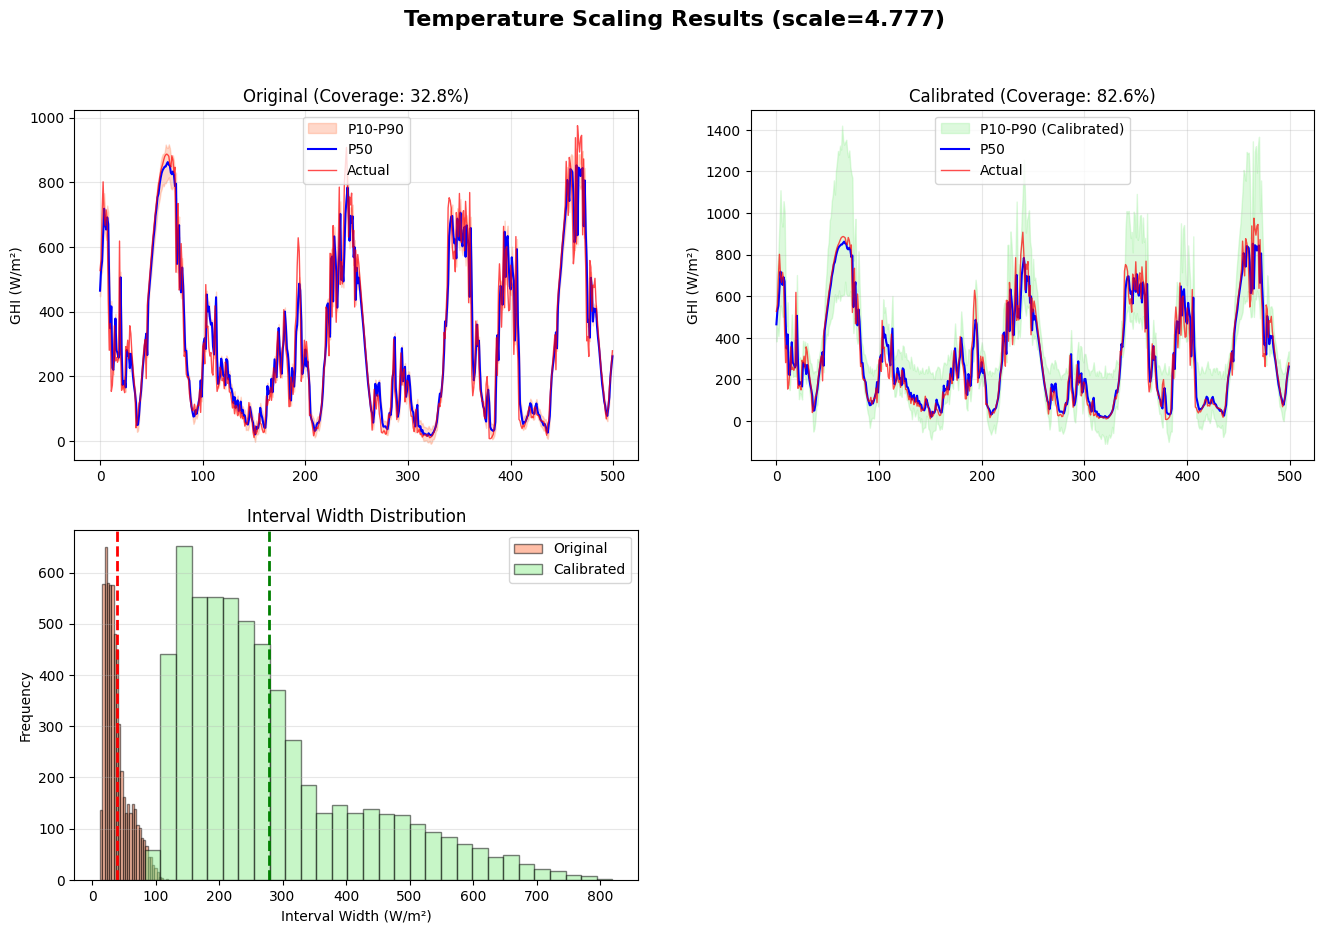

In [63]:
if __name__ == "__main__":
    input_file = './reports2/LSTM_mcdropout_calibrated/15_minutes/quantile_predictions_15_minutes_GHI_P2_H10.csv'
    output_file = './reports2/LSTM_mcdropout_calibrated/15_minutes/quantile_predictions_CALIBRATED_15_minutes_GHI_P2_H10.csv'
    
    scale_factor, df = apply_temperature_scaling(input_file, output_file, target_coverage=80.0)


### Applying Temperature Scaling to all configurations 

In [64]:
REPORT_DIR = './reports2/LSTM_mcdropout_calibrated/15_minutes'
TARGET_COVERAGE = 80.0
VAL_FRACTION = 0.3

In [65]:
def calibrate_all_configs(report_dir=REPORT_DIR, target_coverage=TARGET_COVERAGE):
  
    
    pattern = os.path.join(report_dir, 'quantile_predictions_15_minutes_*.csv')
    all_files = glob(pattern)
    
    pred_files = [f for f in all_files if 'CALIBRATED' not in f]
    
    if len(pred_files) == 0:
        print("No quantile prediction files found")
        print(f"   Looking for: {pattern}")
        return

    print(f"Found {len(pred_files)} configuration files to calibrate\n")
    
    results = []
    
    for i, pred_file in enumerate(pred_files, 1):
        config_name = os.path.basename(pred_file).replace('quantile_predictions_', '').replace('.csv', '')
        
        print(f"[{i}/{len(pred_files)}] Processing: {config_name}")

        
        output_filename = os.path.basename(pred_file).replace(
            'quantile_predictions_', 'quantile_predictions_CALIBRATED_'
        )
        output_path = os.path.join(report_dir, output_filename)
        
        try:
            metrics = process_single_file(pred_file, output_path, target_coverage, VAL_FRACTION)
            
            if metrics is None:
                continue
            
         
            results.append({
                'config': config_name,
                'scale_factor': metrics['scale_factor'],
                'original_coverage_test': metrics['original_coverage_test'],
                'calibrated_coverage_test': metrics['calibrated_coverage_test'],
                'coverage_improvement': metrics['calibrated_coverage_test'] - metrics['original_coverage_test'],
                'original_width_test': metrics['original_width_test'],
                'calibrated_width_test': metrics['calibrated_width_test'],
                'width_increase_pct': ((metrics['calibrated_width_test'] / metrics['original_width_test'] - 1) * 100),
                'status': status,
                'n_samples': metrics['n_samples']
            })
            
        except Exception as e:
            print(f"Error processing {config_name}: {e}\n")
            continue
    
    if len(results) == 0:
        print("\nNo files were successfully processed!")
        return
    
    results_df = pd.DataFrame(results)


    
    display_df = results_df[['config', 'scale_factor', 'original_coverage_test', 
                              'calibrated_coverage_test', 'status']].copy()
    display_df.columns = ['Config', 'Scale', 'Original %', 'Calibrated %', 'Status']
    print(display_df.to_string(index=False))
    

    print(f"\nSuccessfully calibrated: {len(results)}/{len(pred_files)} configs")
    print(f"\nCoverage Statistics:")
    print(f"   Before: {results_df['original_coverage_test'].mean():.1f}% ± {results_df['original_coverage_test'].std():.1f}%")
    print(f"   After:  {results_df['calibrated_coverage_test'].mean():.1f}% ± {results_df['calibrated_coverage_test'].std():.1f}%")
    print(f"   Improvement: +{results_df['coverage_improvement'].mean():.1f}%")
   

    summary_path = os.path.join(report_dir, 'calibration_summary.csv')
    results_df.to_csv(summary_path, index=False)
    
    plot_path = os.path.join(report_dir, 'calibration_batch_summary.png')
    plot_batch_summary(results_df, plot_path)
    
    return results_df


In [66]:
def calculate_coverage(y_true, y_pred_p10, y_pred_p90):
    return np.mean((y_true >= y_pred_p10) & (y_true <= y_pred_p90)) * 100

def calibrate_intervals(y_true, y_pred_p10, y_pred_p50, y_pred_p90, target_coverage=80.0):

    def coverage_error(scale):
        scaled_p10 = y_pred_p50 - scale * (y_pred_p50 - y_pred_p10)
        scaled_p90 = y_pred_p50 + scale * (y_pred_p90 - y_pred_p50)
        
        coverage = calculate_coverage(y_true, scaled_p10, scaled_p90)
        return abs(coverage - target_coverage)
    
    result = minimize_scalar(coverage_error, bounds=(1.0, 10.0), method='bounded')
    return result.x

def process_single_file(input_path, output_path, target_coverage=80.0, val_fraction=0.3):

    df = pd.read_csv(input_path)
    
    if 'y_pred_p10_calibrated' in df.columns:
        print(f"Already calibrated, skipping")
        return None
    
    n_val = int(len(df) * val_fraction)
    df_val = df.iloc[:n_val].copy()
    df_test = df.iloc[n_val:].copy()
    
    y_val = df_val['y_true'].values
    p10_val = df_val['y_pred_p10'].values
    p50_val = df_val['y_pred_p50'].values
    p90_val = df_val['y_pred_p90'].values
    
    original_coverage_val = calculate_coverage(y_val, p10_val, p90_val)
    
    scale_factor = calibrate_intervals(y_val, p10_val, p50_val, p90_val, target_coverage)
    
    df_val['y_pred_p10_calibrated'] = p50_val - scale_factor * (p50_val - p10_val)
    df_val['y_pred_p90_calibrated'] = p50_val + scale_factor * (p90_val - p50_val)
    
    calibrated_coverage_val = calculate_coverage(
        y_val, 
        df_val['y_pred_p10_calibrated'].values,
        df_val['y_pred_p90_calibrated'].values
    )
    
    y_test = df_test['y_true'].values
    p10_test = df_test['y_pred_p10'].values
    p50_test = df_test['y_pred_p50'].values
    p90_test = df_test['y_pred_p90'].values
    
    df_test['y_pred_p10_calibrated'] = p50_test - scale_factor * (p50_test - p10_test)
    df_test['y_pred_p90_calibrated'] = p50_test + scale_factor * (p90_test - p10_test)
    
    original_coverage_test = calculate_coverage(y_test, p10_test, p90_test)
    calibrated_coverage_test = calculate_coverage(
        y_test,
        df_test['y_pred_p10_calibrated'].values,
        df_test['y_pred_p90_calibrated'].values
    )
    
    original_width_test = np.mean(p90_test - p10_test)
    calibrated_width_test = np.mean(
        df_test['y_pred_p90_calibrated'].values - df_test['y_pred_p10_calibrated'].values
    )
    
    df_val['interval_width_calibrated'] = (
        df_val['y_pred_p90_calibrated'] - df_val['y_pred_p10_calibrated']
    )
    df_val['in_interval_calibrated'] = (
        (df_val['y_true'] >= df_val['y_pred_p10_calibrated']) & 
        (df_val['y_true'] <= df_val['y_pred_p90_calibrated'])
    )
    
    df_test['interval_width_calibrated'] = (
        df_test['y_pred_p90_calibrated'] - df_test['y_pred_p10_calibrated']
    )
    df_test['in_interval_calibrated'] = (
        (df_test['y_true'] >= df_test['y_pred_p10_calibrated']) & 
        (df_test['y_true'] <= df_test['y_pred_p90_calibrated'])
    )
    
    df_combined = pd.concat([df_val, df_test], ignore_index=True)
    df_combined.to_csv(output_path, index=False)
    
    metrics = {
        'scale_factor': scale_factor,
        'original_coverage_val': original_coverage_val,
        'calibrated_coverage_val': calibrated_coverage_val,
        'original_coverage_test': original_coverage_test,
        'calibrated_coverage_test': calibrated_coverage_test,
        'original_width_test': original_width_test,
        'calibrated_width_test': calibrated_width_test,
        'n_samples': len(df_combined),
        'n_val': n_val,
        'n_test': len(df_test)
    }
    
    return metrics

def plot_batch_summary(results_df, save_path):
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Batch Temperature Scaling Summary', fontsize=16, fontweight='bold')
    
    ax = axes[0, 0]
    x = np.arange(len(results_df))
    width = 0.35
    
    ax.bar(x - width/2, results_df['original_coverage_test'], width, 
           label='Original', color='coral', alpha=0.7)
    ax.bar(x + width/2, results_df['calibrated_coverage_test'], width,
           label='Calibrated', color='lightgreen', alpha=0.7)
    ax.axhline(y=80, color='red', linestyle='--', linewidth=2, label='Target (80%)')
    ax.axhspan(75, 85, alpha=0.1, color='green', label='Good Range')
    
    ax.set_ylabel('Coverage (%)', fontsize=12)
    ax.set_title('Coverage: Before vs After Calibration', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"C{i+1}" for i in range(len(results_df))], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    ax = axes[0, 1]
    colors = ['green' if 75 <= c <= 85 else 'orange' if 70 <= c < 75 else 'red' 
              for c in results_df['calibrated_coverage_test']]
    bars = ax.bar(x, results_df['scale_factor'], color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='No Scaling')
    ax.set_ylabel('Scale Factor', fontsize=12)
    ax.set_title('Temperature Scaling Factors', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"C{i+1}" for i in range(len(results_df))], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    ax = axes[1, 0]
    width_increase = ((results_df['calibrated_width_test'] / results_df['original_width_test'] - 1) * 100)
    ax.bar(x, width_increase, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_ylabel('Width Increase (%)', fontsize=12)
    ax.set_title('Prediction Interval Width Increase', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"C{i+1}" for i in range(len(results_df))], rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    ax = axes[1, 1]
    ax.axis('off')
    
    n_well_calibrated = sum((results_df['calibrated_coverage_test'] >= 75) & 
                            (results_df['calibrated_coverage_test'] <= 85))
    n_acceptable = sum((results_df['calibrated_coverage_test'] >= 70) & 
                       (results_df['calibrated_coverage_test'] <= 90))
    
    avg_improvement = (results_df['calibrated_coverage_test'] - 
                      results_df['original_coverage_test']).mean()
    
    
    ax.text(0.05, 0.5, summary_text, fontsize=9, family='monospace',
           verticalalignment='center', transform=ax.transAxes,
           bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()


In [67]:
def calibrate_all_configs(report_dir=REPORT_DIR, target_coverage=TARGET_COVERAGE):


    print("Batch Temperature Scaling")
    
    pattern = os.path.join(report_dir, 'quantile_predictions_15_minutes_*.csv')
    all_files = glob(pattern)
    
    pred_files = [f for f in all_files if 'CALIBRATED' not in f]
    
    if len(pred_files) == 0:
        print("No quantile prediction files found!")
        print(f"   Looking for: {pattern}")
        return
    
    print(f"Found {len(pred_files)} configuration files to calibrate\n")
    
    results = []
    
    for i, pred_file in enumerate(pred_files, 1):
        config_name = os.path.basename(pred_file).replace('quantile_predictions_', '').replace('.csv', '')
        
        print(f"[{i}/{len(pred_files)}] Processing: {config_name}")

        
        output_filename = os.path.basename(pred_file).replace(
            'quantile_predictions_', 'quantile_predictions_CALIBRATED_'
        )
        output_path = os.path.join(report_dir, output_filename)
        
        try:
            metrics = process_single_file(pred_file, output_path, target_coverage, VAL_FRACTION)
            
            if metrics is None:
                continue
   

            results.append({
                'config': config_name,
                'scale_factor': metrics['scale_factor'],
                'original_coverage_test': metrics['original_coverage_test'],
                'calibrated_coverage_test': metrics['calibrated_coverage_test'],
                'coverage_improvement': metrics['calibrated_coverage_test'] - metrics['original_coverage_test'],
                'original_width_test': metrics['original_width_test'],
                'calibrated_width_test': metrics['calibrated_width_test'],
                'width_increase_pct': ((metrics['calibrated_width_test'] / metrics['original_width_test'] - 1) * 100),
                'status': status,
                'n_samples': metrics['n_samples']
            })
            
        except Exception as e:
            print(f"Error processing {config_name}: {e}\n")
            continue
    
    if len(results) == 0:
        print("\nNo files were successfully processed!")
        return
    
    results_df = pd.DataFrame(results)

    
    display_df = results_df[['config', 'scale_factor', 'original_coverage_test', 
                              'calibrated_coverage_test', 'status']].copy()
    display_df.columns = ['Config', 'Scale', 'Original %', 'Calibrated %', 'Status']
    print(display_df.to_string(index=False))

    
    
    summary_path = os.path.join(report_dir, 'calibration_summary.csv')
    results_df.to_csv(summary_path, index=False)
    
    plot_path = os.path.join(report_dir, 'calibration_batch_summary.png')
    plot_batch_summary(results_df, plot_path)

    
    return results_df


In [ ]:
results = calibrate_all_configs()
